In [ ]:
install.packages("lmtest")

In [127]:
ox <- read.csv("sample_data/properties.csv")
cam <- read.csv("sample_data/camproperties.csv")
df <- rbind(ox, cam)

## Data Preprocessing

### Data Cleaning

In [128]:
head(df)

,price,areaCode,propertyType,areaValue,areaUnit,bedrooms,bathrooms,receptions,epcRating,tenure,councilTaxBand
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1075000,OX1,House,2155.0,sq ft,3,2,2,,Freehold,TBC
2,650000,OX25,New development,NA,,NaN,NaN,NaN,,Freehold,TBC
3,2750000,OX28,House,8248.0,sq ft,10,5,4,E,Freehold,H
4,950000,OX2,Flat / Apartment,1632.0,sq ft,3,2,2,C,Leasehold. Lease Expiry: 04/05/2128 (102 years remaining),F
5,615000,OX1,Flat / Apartment,826.0,sq ft,2,2,1,B,Leasehold. Lease Expiry: 01/09/2142 (117 years remaining),E
6,1750000,RG9,House,1.6,Ac,5,3,3,E,Freehold,F


In [129]:
library(dplyr)

In [130]:
listings <- na.omit(df)
listings <- listings[listings$councilTaxBand != "TBC", ]
listings <- listings[!apply(listings == "", 1, any), ]

listings <- listings[listings$areaUnit != "Ac", ]

listings$tenure_clean <- ifelse(grepl("Share of Freehold", listings$tenure, ignore.case = TRUE),
                                "Share of Freehold",
                         ifelse(grepl("Leasehold", listings$tenure, ignore.case = TRUE),
                                "Leasehold",
                                "Freehold"))

listings$tenure_clean <- factor(listings$tenure_clean,
                                levels = c("Freehold", "Leasehold", "Share of Freehold"))
                                one_hot <- model.matrix(~ tenure_clean - 1, data = listings)

head(listings)

,price,areaCode,propertyType,areaValue,areaUnit,bedrooms,bathrooms,receptions,epcRating,tenure,councilTaxBand,tenure_clean
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>
3,2750000,OX28,House,8248,sq ft,10,5,4,E,Freehold,H,Freehold
4,950000,OX2,Flat / Apartment,1632,sq ft,3,2,2,C,Leasehold. Lease Expiry: 04/05/2128 (102 years remaining),F,Leasehold
5,615000,OX1,Flat / Apartment,826,sq ft,2,2,1,B,Leasehold. Lease Expiry: 01/09/2142 (117 years remaining),E,Leasehold
7,899995,OX7,House,2246,sq ft,4,3,2,D,Freehold,G,Freehold
8,595000,OX2,House,1323,sq ft,4,5,2,C,Freehold,E,Freehold
10,800000,RG9,House,1931,sq ft,4,2,2,E,Freehold,D,Freehold


Several changes were made to the dataset:


1.   Removed all incomplete records
2.   Removed all area measurements that were not in square feet
3.   Standardised tenure to be either "Freehold", "Leasehold", or "Share of Freehold"



In [131]:
nrow(df)
nrow(listings)

[1] 525

[1] 274

Cleaning removed 251 records.

In [132]:
listings$isFreehold <- as.integer(listings$tenure_clean == "Freehold")
listings$isHouse <- ifelse(listings$propertyType == "House", 1, 0)

listings$epc_numeric <- as.integer(factor(listings$epcRating, levels = c("G", "F", "E", "D", "C", "B", "A")))

listings$tax_numeric <- as.integer(factor(listings$councilTaxBand,levels = c("A", "B", "C", "D", "E", "F", "G", "H")))

head(listings)

,price,areaCode,propertyType,areaValue,areaUnit,bedrooms,bathrooms,receptions,epcRating,tenure,councilTaxBand,tenure_clean,isFreehold,isHouse,epc_numeric,tax_numeric
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<int>,<dbl>,<int>,<int>
3,2750000,OX28,House,8248,sq ft,10,5,4,E,Freehold,H,Freehold,1,1,3,8
4,950000,OX2,Flat / Apartment,1632,sq ft,3,2,2,C,Leasehold. Lease Expiry: 04/05/2128 (102 years remaining),F,Leasehold,0,0,5,6
5,615000,OX1,Flat / Apartment,826,sq ft,2,2,1,B,Leasehold. Lease Expiry: 01/09/2142 (117 years remaining),E,Leasehold,0,0,6,5
7,899995,OX7,House,2246,sq ft,4,3,2,D,Freehold,G,Freehold,1,1,4,7
8,595000,OX2,House,1323,sq ft,4,5,2,C,Freehold,E,Freehold,1,1,5,5
10,800000,RG9,House,1931,sq ft,4,2,2,E,Freehold,D,Freehold,1,1,3,4


## Data Transformation

### Transformations were applied to categorical variables to make the suitable for modelling:


1.   Standardised area measurements to square feet. This ensures consistnecy across the dataset, avoiding confusion or model distortion from mixed units.
2.   Converted the tenure column to a boolean (1 = Freehold, 0 = other). Since most properties are Freehold (181 out of 191), simplifying it into a binary format captures the key distinction while making it numeric for modeling.
3.   Also converted property type to a boolean (1 = House, 0 = other) for the same reason. 177 out of 191 properties in the dataset are houses.
4.   Encoded EPC rating and council tax band as ordered numeric values. These variables have a natural order (e.g., A > B > C), so ordinal encoding preserves that structure. One-hot encoding was avoided to maintain this order and reduce dimensionality.



The number of houses is large compared to other property types, this means one-hot encoding is not appropriate for this data. Instead we'll turn property type into a boolean to check whether it's a house or not.

In [133]:
set.seed(123
)

train_indices <- sample(seq_len(nrow(listings)), size = 0.8 * nrow(listings))
train_data <- listings[train_indices,]
test_data <-  listings[-train_indices,]
colnames(listings)

[1] "price"          "areaCode"       "propertyType"   "areaValue"     
 [5] "areaUnit"       "bedrooms"       "bathrooms"      "receptions"    
 [9] "epcRating"      "tenure"         "councilTaxBand" "tenure_clean"  
[13] "isFreehold"     "isHouse"        "epc_numeric"    "tax_numeric"

## Fitting the Model

In [134]:
cor(listings[c("price", "bedrooms", "bathrooms", "receptions", "areaValue", "tax_numeric", "epc_numeric", "isHouse", "isFreehold")])

,price,bedrooms,bathrooms,receptions,areaValue,tax_numeric,epc_numeric,isHouse,isFreehold
price,1.0000000,0.6299036,0.4779208,0.5301252,0.7687269,0.5572154,-0.1358677,0.1998092,0.2049569
bedrooms,0.6299036,1.0000000,0.6349406,0.6174808,0.8010057,0.6409275,-0.2016641,0.4401570,0.4518488
bathrooms,0.4779208,0.6349406,1.0000000,0.2904452,0.5655494,0.4551305,0.1198702,0.2315814,0.2311628
receptions,0.5301252,0.6174808,0.2904452,1.0000000,0.6677463,0.4903545,-0.4089866,0.3052791,0.3468288
areaValue,0.7687269,0.8010057,0.5655494,0.6677463,1.0000000,0.6140784,-0.2313214,0.2606716,0.2959348
tax_numeric,0.5572154,0.6409275,0.4551305,0.4903545,0.6140784,1.0000000,-0.1399880,0.2640120,0.3053860
epc_numeric,-0.1358677,-0.2016641,0.1198702,-0.4089866,-0.2313214,-0.1399880,1.0000000,-0.2404516,-0.1757214
isHouse,0.1998092,0.4401570,0.2315814,0.3052791,0.2606716,0.2640120,-0.2404516,1.0000000,0.8759700
isFreehold,0.2049569,0.4518488,0.2311628,0.3468288,0.2959348,0.3053860,-0.1757214,0.8759700,1.0000000


In [135]:
full_model <- lm(log(price) ~ (bedrooms + bathrooms + receptions + areaValue)^2 +
               tax_numeric + epc_numeric + isHouse + isFreehold, data = train_data)

null_model <- lm(log(price) ~ 1, data = train_data)

step_model <- step(full_model, scope = list(lower = null_model, upper = full_model), direction = "both")

summary(step_model)

Start:  AIC=-535.87
log(price) ~ (bedrooms + bathrooms + receptions + areaValue)^2 + 
    tax_numeric + epc_numeric + isHouse + isFreehold

                       Df Sum of Sq    RSS     AIC
- bedrooms:bathrooms    1   0.00023 16.530 -537.87
- bedrooms:areaValue    1   0.00176 16.532 -537.85
- isFreehold            1   0.02576 16.556 -537.53
- isHouse               1   0.05641 16.586 -537.13
- bathrooms:areaValue   1   0.06483 16.595 -537.02
<none>                              16.530 -535.87
- epc_numeric           1   0.19291 16.723 -535.33
- bathrooms:receptions  1   0.30018 16.830 -533.93
- bedrooms:receptions   1   0.83661 17.366 -527.06
- receptions:areaValue  1   0.94204 17.472 -525.74
- tax_numeric           1   2.81071 19.341 -503.48

Step:  AIC=-537.87
log(price) ~ bedrooms + bathrooms + receptions + areaValue + 
    tax_numeric + epc_numeric + isHouse + isFreehold + bedrooms:receptions + 
    bedrooms:areaValue + bathrooms:receptions + bathrooms:areaValue + 
    receptions:ar


Call:
lm(formula = log(price) ~ bedrooms + bathrooms + receptions + 
    areaValue + tax_numeric + epc_numeric + bedrooms:receptions + 
    bathrooms:receptions + bathrooms:areaValue + receptions:areaValue, 
    data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69315 -0.20821  0.00897  0.17072  0.81254 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.188e+01  1.854e-01  64.111  < 2e-16 ***
bedrooms              3.027e-01  6.790e-02   4.458 1.35e-05 ***
bathrooms            -7.852e-02  6.614e-02  -1.187 0.236526    
receptions            1.023e-01  9.373e-02   1.092 0.276163    
areaValue             2.021e-05  9.681e-05   0.209 0.834845    
tax_numeric           1.465e-01  2.422e-02   6.047 6.76e-09 ***
epc_numeric           2.600e-02  1.852e-02   1.404 0.161816    
bedrooms:receptions  -1.048e-01  2.417e-02  -4.335 2.27e-05 ***
bathrooms:receptions  6.314e-02  2.912e-02   2.169 0.031243 *  
bathrooms

Stepwise regressions is an iterative method used to select a subset of predictor variables that best explain the variation in the response variable, balancing model fit and complexity. It begins with a null model (the simplest possible model which is just the intercept) and evaluates the addition or removal of predictors to improve the model based on the Akaike Information Criterion (AIC).

Starting from the null model, variables are added one by one if they reduce the AIC. after adding main effects, the process explored interaction terms that capture combined effects of variables on the response.

At each step, the algorithm evaluates whether adding or removing a variable improves the model. This continues until no further improvement in AIC is possible, resulting in an optimised final model.

The final model explains about 67.1% of the variance (adjust R<sup>2</sup>=0.671), showing that the seleted features and their interactions capture key factors influencing price.

## Model validation

### Multicollinearity

In [136]:
manual_vif <- function(df) {
  vif_values <- numeric(ncol(df))
  names(vif_values) <- colnames(df)

  for (i in seq_along(df)) {
    temp <- data.frame(response = df[[i]], df[, -i, drop = FALSE])
    model <- lm(response ~ ., data = temp)
    r2 <- summary(model)$r.squared
    vif_values[i] <- 1 / (1 - r2)
  }

  return(vif_values)
}

vif_results <- manual_vif(vif_df)
print(round(vif_results, 2))




   bedrooms   bathrooms  receptions   areaValue tax_numeric epc_numeric 
       4.19        1.97        2.20        3.60        1.81        1.36 
    isHouse 
       1.33 


VIF values were calculated to assess multicollinearity among predictors. All VIFs are below 5, indicating no serious multicollinearity concerns. The hifhest VIF is for bedrooms (4.19), which is still within acceptable limits. Other predictors show low to moderate VIGs, suggesting the predictors are sufficiently independent for regression modelling.

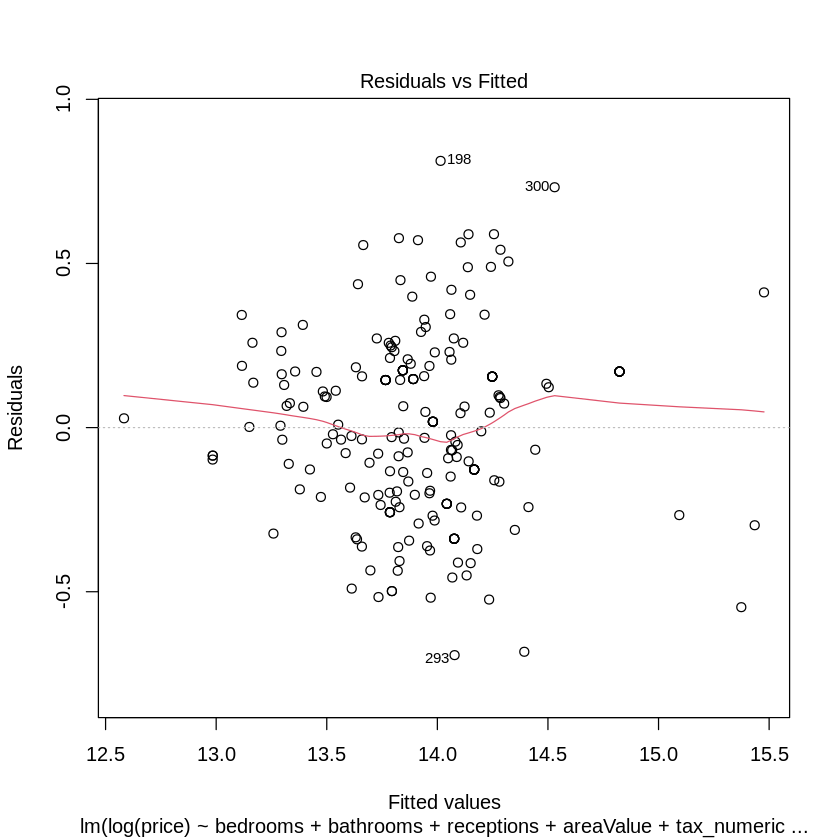

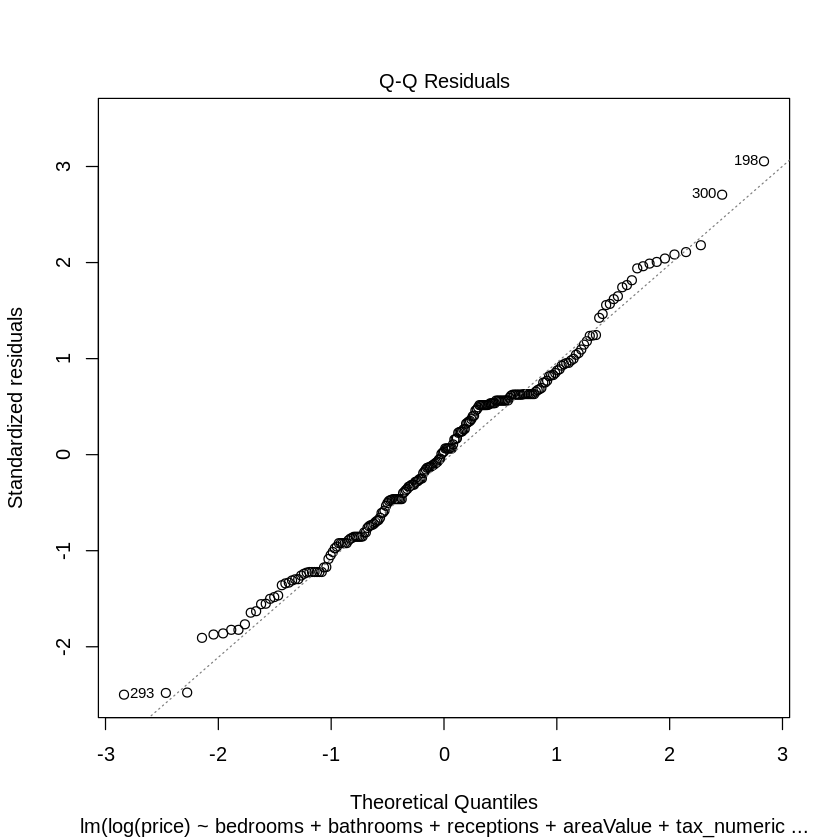

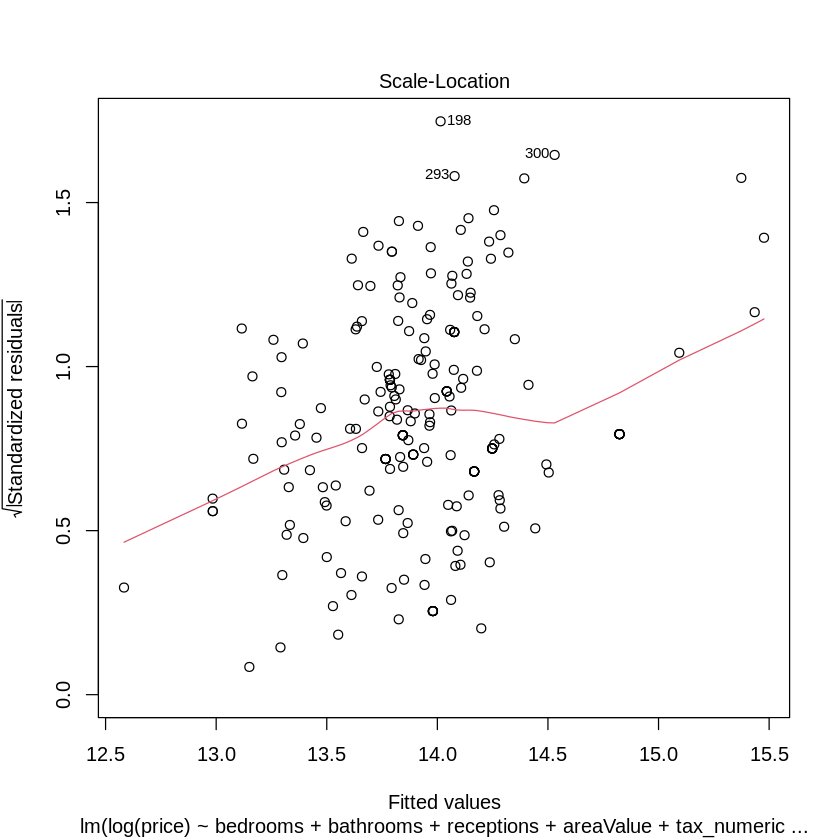

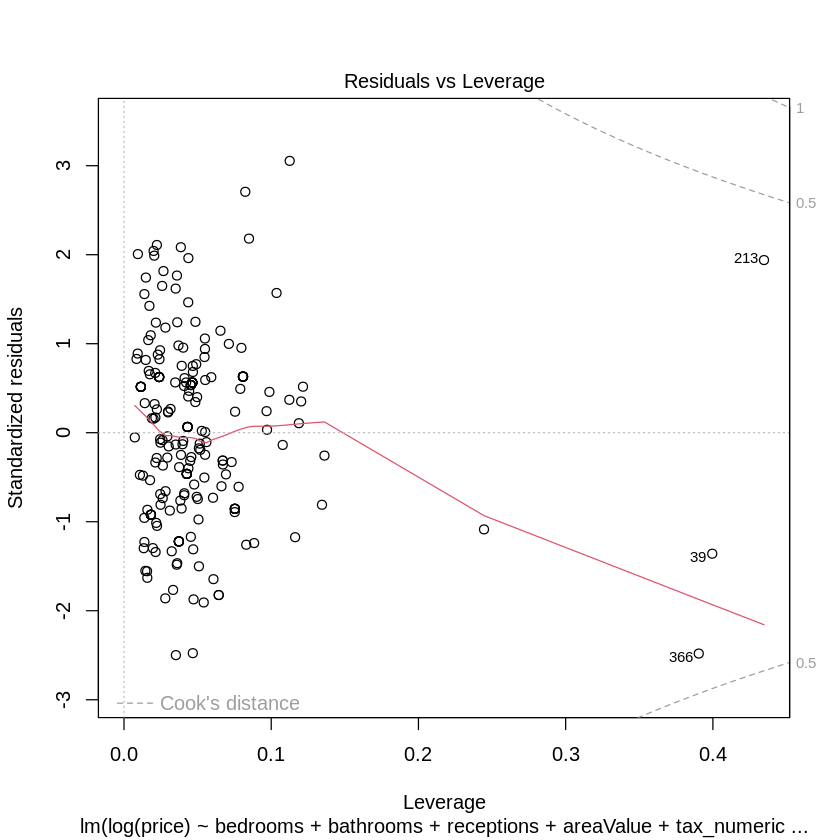

In [137]:
plot(step_model)

### Diagnostic Plots

#### Residuals vs Fitted

The red trend line stays mostly between 0 and 0.1 on the residual axis, showing residuals are generally small but slightly positive. The subtle wabe-like pattern indicates minor systemaitc deviations, suggesting the model slightly under-predicts most values. Overall, residuals remain close to zero, implying a reasonable fit.

#### Q-Q Residuals

The Q-Q plot shows that residuals closely follow a straight diagonal line, with only slight deviations at the extremes. This indicates that the residuals are approximately normally distributed, supporting the assumption of normality.

#### Scale-Location

The trend line shows a clear positive trend, indicating that the spread of residuals increases with fitted values. This suggests heteroscedasticity, meaning the variance of errors grows as predicted values get larger, which may violate the constant variance assumption of linear regression.

#### Residual vs Leverage

The plot is mostly flat for Cook's distance values between 0 and 0.1, then shows a steep decline. Three notable outliers are identified: point 213 with a high positive residual about +2 leverage, point 366 with a large negative residual about -2.5, and point 39 with a residual near -1.5. These influential points may disproportionately affect the model and warrant further investigation.


In [138]:
library(lmtest)

In [139]:
bptest(step_model)



	studentized Breusch-Pagan test

data:  step_model
BP = 15.126, df = 10, p-value = 0.1275


### Testing for Heteroscedasticity

A Breusch-Pagan test was conducted to assess heteroscedasticity in the model residuals. With a p-value of 0.1275, this is no sufficient evidence to reject the null hypothesis of constant variance. This suggests that, despite the results of the Scale-Location diagnostic plot, heteroscedasticity is not a significant concern.

### Diagnosis

Overall, the key assumptions of a linear regression model are reasonably met. The Q-Q plot indicates that the residuals are approximately normally distributed, and the Breush-Pagan test suggests homoscedasticity. The residuals vs fitted plot shows no clear non-linear patterns, supporting the assumption of linearity between predictors and the response. Together, these findings show that it is reasonable to model this data using a linear regression model.

In [140]:
log_predictions <- predict(step_model, newdata = test_data)

predictions <- exp(log_predictions)

actual <- test_data$price

mape <- function(actual, predicted) {
  mean(abs((actual - predicted) / actual)) * 100
}

model_mape <- mape(actual, predictions)
rmse <- sqrt(mean((predictions - actual)^2))

sse <- sum((predictions - actual)^2)
sst <- sum((actual - mean(actual))^2)
r_squared <- 1 - sse / sst

cat("RMSE (original scale):", rmse, "\nR-squared (original scale):", r_squared, "\nMAPE (original scale):", model_mape, "%\n")



RMSE (original scale): 283587.7 
R-squared (original scale): 0.7903595 
MAPE (original scale): 21.84342 %


### Testing the Model

After fitting the model on the training set, predictions for the test set were generated on the original price scale by exponentiating the log-predictions:

`predictions <- exp(log_predictions)`  
`actual <- test_data$price`

The following metrics were calculated to evaluate the model's performance on the test data:

- **Mean Absolute Percentage Error (MAPE):**  
  Measures the average percentage difference between predicted prices and actual prices.  
  **Result:** 21.84%  
  **Interpretation:** On average, predictions are about 21.8% away from the true prices.  
  This is moderate accuracy.

- **Root Mean Squared Error (RMSE):**  
  Represents the square root of the average squared differences between predicted and actual prices.  
  **Result:** £283,587.7
  **Interpretation:** On average, predictions deviate by about £283k from actual prices, with larger errors weighted more heavily.  
  This is reasonable considering the average house price in the dataset is over £1,000,000.

- **R-squared (on the original scale):**  
  Shows the proportion of variance in actual prices explained by the model.  
  **Result:** 0.7904  
  **Interpretation:** The model explains about 79% of the variability in property prices.  
  Yes, this is quite strong. An R² close to 0.8 indicates the model captures most of the important relationships in the data.


## Final Summary

### Model Formula

```r
log(price) ~ bedrooms + bathrooms + receptions + areaValue +
    tax_numeric + epc_numeric + bedrooms:receptions +
    bathrooms:receptions + bathrooms:areaValue + receptions:areaValue
```
### Model Summary and Interpretation

The final selected model explains approximately **67.1% of the variation** in the logarithm of property prices (adjusted R² = 0.671), indicating a good fit.

## Key takeaways

- **Number of bedrooms (`bedrooms`)** is a significant positive predictor and interacts notably with receptions, reflecting that the combined effect of bedrooms and reception rooms influences price.
- **Council tax band (`tax_numeric`)** is a highly significant positive predictor, highlighting the importance of location and local valuation tiers.
- **Property size (`areaValue`)** does not have a significant main effect alone, but shows significant interactions with bathrooms and receptions, suggesting size impacts price differently depending on these features.
- **Bathrooms (`bathrooms`)** have a non-significant main effect, but the interaction with receptions is positive and significant, indicating bathrooms add more value in homes with more reception rooms.
- **Receptions (`receptions`)** alone are not significant but play an important role through interactions with bedrooms, bathrooms, and area.
- **Energy Performance Certificate (`epc_numeric`)** is included but not statistically significant at conventional levels.
- Interaction terms reveal important combined effects:
  - `bedrooms:receptions` is strongly negative, implying a complex interplay reducing the additive effect of bedrooms when receptions increase.
  - `bathrooms:receptions` is positively significant.
  - `bathrooms:areaValue` shows a marginal negative effect.
  - `receptions:areaValue` shows a significant positive effect.

## Model diagnostics

- Residual standard error on log(price) is approximately **0.282**, showing reasonable model fit.
- Multiple R-squared: **0.6861**, Adjusted R-squared: **0.671**, shows good explanatory power.
- AIC of **-543.06** indicates the model balances fit and parsimony well.

## Interpretation

The model highlights that property price depends on complex interactions between features rather than isolated effects. Bedrooms, bathrooms, and receptions influence price jointly rather than independently. Size interacts with both bathrooms and receptions, suggesting the marginal impact of area depends on the home’s layout. Council tax band remains an important standalone factor, emphasizing location influence. Although some main effects are not significant, their interactions reveal nuanced relationships that are critical to understanding price variation.

## Recommendations

- Consider exploring non-linear transformations or alternative regression techniques to capture potential non-linearities and heteroscedasticity.
- Investigate adding spatial variables such as postcode or neighborhood to capture location effects more granularly.
- Validate model performance on out-of-sample data for robustness.
- Use these insights to guide property valuation, focusing on how combinations of features jointly affect price rather than interpreting features in isolation.


